In [1]:
import pandas as pd
from matplotlib import pyplot as plt
from dataclasses import dataclass
import numpy as np
from typing import Optional, List
from backtest_broker import Position, Broker
from copy import deepcopy
from backtest import BackTestResults

%load_ext autoreload
%autoreload 2

In [2]:
@dataclass
class FeeConfig:
    broker: Optional[float] = None
    slipage: Optional[float] = None
    W: Optional[float] = None
    R: Optional[float] = None
    base: Optional[float] = None

class Comission():
    def __init__(self, config:FeeConfig):
        self.params = config

    def _calc_stock_comission(self, price):
        return round(price*self.params.W/self.params.R*self.params.base/100, 2)

    def __call__(self, price, is_taker:bool):
        com = self.params.broker
        if is_taker:
            com += self._calc_stock_comission(price) + self.params.slipage
        return com
    
fee_calculator = Comission(FeeConfig(broker=0.7, slipage=1, W=1, R=1, base=0.00462))

In [6]:
df = pd.read_csv("/Users/andrybin/Yandex.Disk.localized/Data/validation/DMA@Si-M15.txt")
# df["Volume"] = df.Type.abs()
# df.Type /= df.Volume
df.Time = list(map(np.datetime64, pd.to_datetime(df.Time)))
df

,Symbol,TSize,TValue,Margin,Time,Price,Type,SL
0,ALLFUTSi,1.0,1.0,0,2015-01-05 10:59:57,59985.0,1,0
1,ALLFUTSi,1.0,1.0,0,2015-01-05 12:29:58,59691.0,-2,0
2,ALLFUTSi,1.0,1.0,0,2015-01-05 14:29:57,60176.0,2,0
3,ALLFUTSi,1.0,1.0,0,2015-01-06 18:44:58,64520.0,-2,0
4,ALLFUTSi,1.0,1.0,0,2015-01-06 20:44:58,64858.0,2,0
...,...,...,...,...,...,...,...,...
7352,ALLFUTSi,1.0,1.0,0,2024-05-30 18:29:57,90531.0,-2,0
7353,ALLFUTSi,1.0,1.0,0,2024-05-30 20:14:59,90532.0,2,0
7354,ALLFUTSi,1.0,1.0,0,2024-05-30 20:59:58,90539.0,-2,0
7355,ALLFUTSi,1.0,1.0,0,2024-05-30 21:59:57,90537.0,2,0


In [7]:
df.Time.iloc[0]

Timestamp('2015-01-05 10:59:57')

In [11]:
profits, fees = [0], [fee_calculator(df.Price.iloc[0], df.SL.iloc[0] > 0)]
last_type = df.Type.iloc[0]
last_pos: List[Position] = Position(df.Price.iloc[0], df.Time.iloc[0],0)
positions = []

for i in range(1, len(df)):
    cur_prof = last_type*(df.Price.iloc[i]-df.Price.iloc[i-1])
    cur_fee = fee_calculator(df.Price.iloc[i-1], df.SL.iloc[i] > 0)
    # print(last_type, cur_prof, df.SL.iloc[i], cur_fee)
    last_type = df.Type.iloc[i] + last_type
    if last_pos is not None:
        last_pos.close(df.Price.iloc[i], df.Time.iloc[i], i)
    profits.append(cur_prof)
    fees.append(cur_fee)
    if last_pos is not None:
        positions.append(last_pos)
    last_pos = None
    if last_type != 0:
        last_pos = Position(df.Price.iloc[i]*np.sign(last_type), np.datetime64(df.Time.iloc[i]), i, volume=abs(last_type), 
                            fee_rate=0.01)

2024-07-23 23:37:22.003 | DEBUG    | backtest_broker:__init__:83 - 2015-01-05 10:59:57 open position 0-BUY-59985.00-1.0
2024-07-23 23:37:22.004 | DEBUG    | backtest_broker:close:116 - 2015-01-05 12:29:58 close position 0-BUY-59985.00-1.0 at 59691.00, profit: -0.49
2024-07-23 23:37:22.005 | DEBUG    | backtest_broker:__init__:83 - 2015-01-05T12:29:58 open position 1-SELL-59691.00-1.0
2024-07-23 23:37:22.005 | DEBUG    | backtest_broker:close:116 - 2015-01-05 14:29:57 close position 1-SELL-59691.00-1.0 at 60176.00, profit: -0.83
2024-07-23 23:37:22.006 | DEBUG    | backtest_broker:__init__:83 - 2015-01-05T14:29:57 open position 2-BUY-60176.00-1.0
2024-07-23 23:37:22.006 | DEBUG    | backtest_broker:close:116 - 2015-01-06 18:44:58 close position 2-BUY-60176.00-1.0 at 64520.00, profit: 7.20
2024-07-23 23:37:22.007 | DEBUG    | backtest_broker:__init__:83 - 2015-01-06T18:44:58 open position 3-SELL-64520.00-1.0
2024-07-23 23:37:22.007 | DEBUG    | backtest_broker:close:116 - 2015-01-06 20:4

In [12]:
br = Broker(None)

br.positions = positions

In [13]:
bres = BackTestResults("2015-01-01", "2024-06-01", 100000)
bres.wallet = 100000
bres.process_backtest(br)

0.27295749983750284

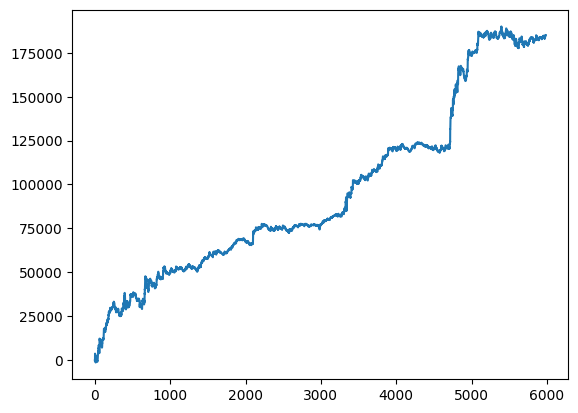

In [20]:
# plt.plot(np.array(profits).cumsum())    
plt.plot(br.profits_abs.cumsum() + br.fees.cumsum())
# plt.plot(np.array(profits).cumsum() - np.array(fees).cumsum()) 

In [ ]:
br = BackTestResults("2015-01-01", "2024-06-01", 100000)
br.process_profits(dates, profits, fees)

NameError: name 'dates' is not defined